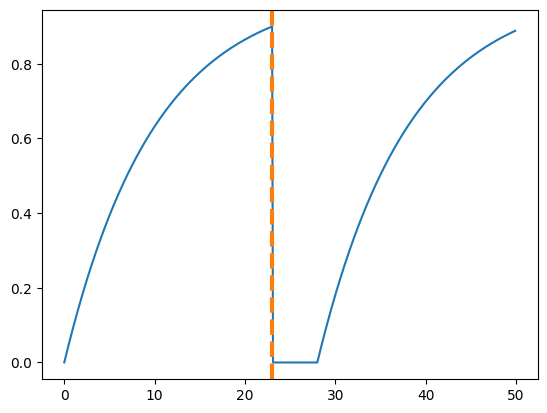

In [2]:
from brian2 import *
import numpy as np
%matplotlib inline


tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1  (unless refractory)
'''
#adding unless refractory mean s that this DE determines the behaviour of the neuron UNLESS it is in the refractory period
#in that case it stays constant

G = NeuronGroup(1, eqs, threshold = 'v>0.9', reset = 'v = 0', refractory=5*ms, method = 'exact')

statemon = StateMonitor(G, 'v', record=0) 
spikemon = SpikeMonitor(G)

run(50*ms)


plt.plot(statemon.t/ ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls = '--', c='C1', lw=3)
xlabel = 'Time (ms)'
ylabel = 'v'
plt.show()


so above, we have introduced the neuron group, where we can specify the number of neurons, and the DE that they follow. statemonitor and spike monitor then record the behaviour of a particular neuron group, and whatever quantity you will to record. 

within the group, you can also specify the threshold and resed values, as seen above. 
furthermore, adding the note 'unless refractory' in the ''' eqs ''' list means that if in a refractory period, the neuron will not obey that equation, as such it is seen stationary. 

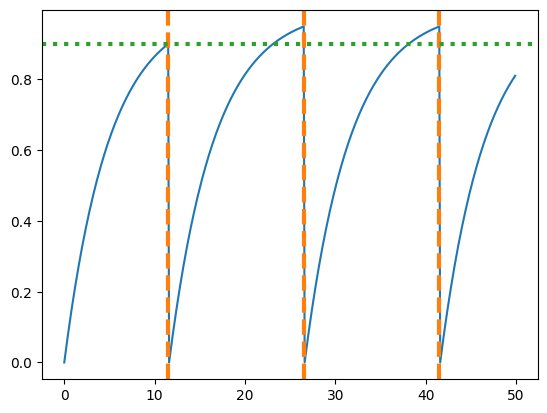

Spike times: [11.5 26.5 41.5] ms


In [3]:
tau = 5*ms
eqs = '''
dv/dt = (1-v)/tau : 1  
'''
#adding unless refractory mean s that this DE determines the behaviour of the neuron UNLESS it is in the refractory period
#in that case it stays constant

G = NeuronGroup(1, eqs, threshold = 'v>0.9', reset = 'v = 0', refractory=15*ms, method = 'exact')

statemon = StateMonitor(G, 'v', record=0) 
spikemon = SpikeMonitor(G)

run(50*ms)


plt.plot(statemon.t/ ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls = '--', c='C1', lw=3)
axhline(0.9, ls=':', c='C2', lw=3)
xlabel = 'Time (ms)'
ylabel = 'v'
plt.show()

print("Spike times: %s" % spikemon.t[:])


different behaviour here, can see that since the inhib period is longer, when you rise above this, the neuron does not spike. at 11.5 + 15 = 26.5 though it DOES, and resets to 0 before immediately rising, as there isnt an inhibitory clause in the eqns. 

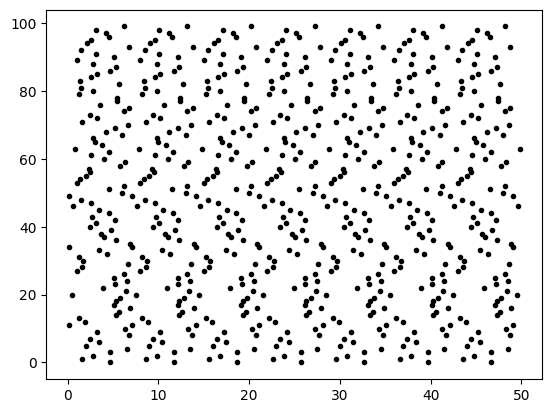

In [4]:
#multiple neurons

N = 100
tau = 10*ms

start_scope()

N = 100
tau = 10*ms
eqs = '''
dv/dt = (2-v)/tau : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact')
G.v = 'rand()'  #this gives a random initialisation for each neuron before the run

spikemon = SpikeMonitor(G)
statemon = StateMonitor(G, 'v', record=True)
run(50*ms)


plot(spikemon.t/ms, spikemon.i, '.k')   #spikemon gives the index for each neuron that spikes
xlabel = 'Time (ms)'
ylabel = 'Neuron index'

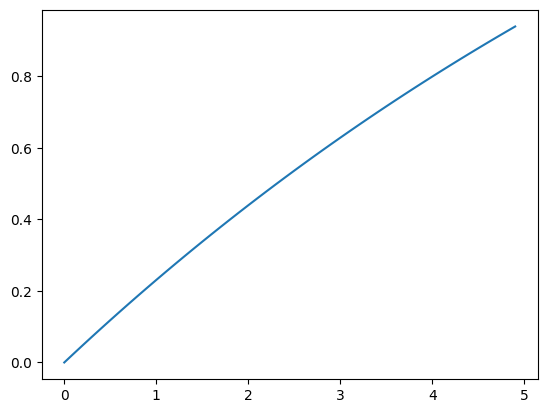

Text(0, 0.5, 'Firing rate (sp/s)')

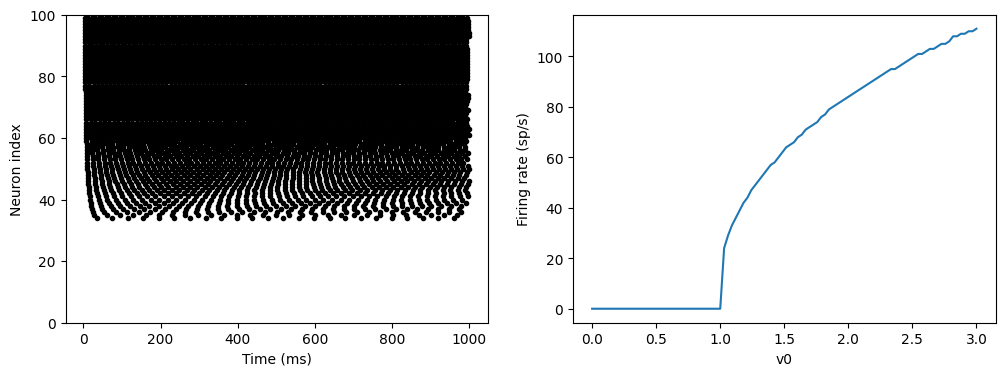

In [5]:
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms

eqs = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

#v0  1 declares a new per neuron param, v0, with units of 1 (dimless)


G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
M = SpikeMonitor(G)
S = StateMonitor(G, 'v', record = 80)

G.v0 = 'i*v0_max/(N-1)'
#this then initialises v0 for each neuron from 0 to v0_max. e.g. for the first
#neuron with i = 0 , v0 = 0 , for the last neuron with i = N-1, v0 = v0_max

run(duration)

plt.plot(S.t[0:50]/ ms, S.v[0][0:50])
plt.show()

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
plt.xlabel('Time (ms)')
plt.ylim(0, N)
plt.ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
plt.xlabel('v0')
plt.ylabel('Firing rate (sp/s)')


so this model is driving each neuron to v0_max, but spikes at v>1. rate for firing is related to the value of v0. for v0<1, it will never spike, as you are driven to v0 which is less than the threshold. . as v0 gets larger, it will spike more frequenctly. 
right hand plot shows rate as a function of v0. 
we have found rate from M.count - this is an array of # of spikes fired by each neuron in the group.
for all v0 below the threshold there is no spiking  

-30. mV


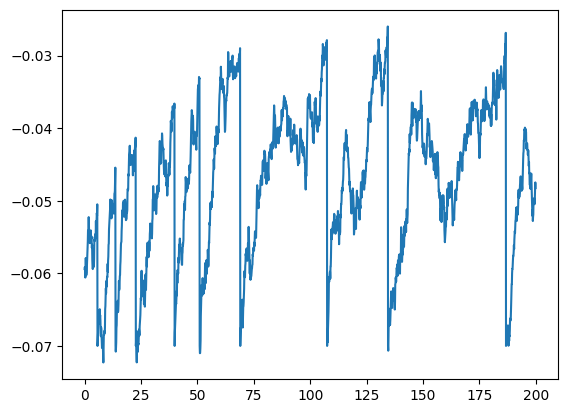

Text(0, 0.5, 'Instantaneous firing rate (sp/s)')

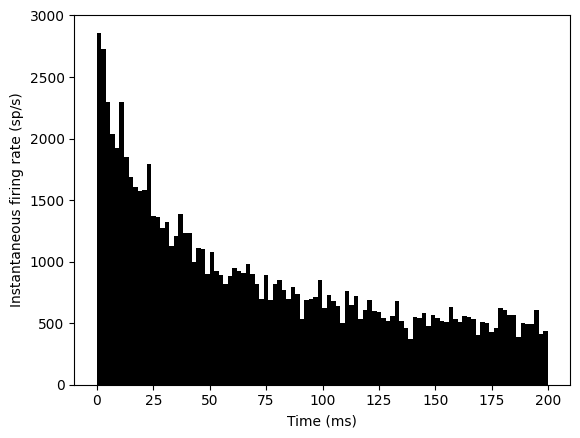

In [6]:
start_scope()

N = 1000
tau = 10*ms
vr = -70*mV    #this is some sort of reset potential
vt0 = -50*mV     #this is a baseline threshold potential  - potential to spike
delta_vt0 = 5*mV        #threshold adaptation increment  - increase the threshold after each spike
tau_t = 250*ms      #time constant for threshold adaptation   - how fast the threshold recoveres after an increase
sigma = 0.5 * (vt0 - vr)    #noise intensity
v_drive = 2*(vt0 - vr)  #drive force for the neuron
duration = 200*ms


print(v_drive + vr)
eqs  = '''
dv/dt = (v_drive + vr - v)/ tau + sigma * xi * tau ** -0.5 : volt
dvt/dt = (vt0 - vt)/tau_t : volt
'''
# so we pull v to v_crive + vr
#we also have a stochastic term with some gaussian white noise  scaled by sigma
#dvt/dt makes the threshold also variable, it decays back to vt0 with time constant tau/t. 


reset = '''
v = vr
vt += delta_vt0
'''

#this means that when the neuron spikes for v ? vt, v will reset to vr, and the threshold will change by delta. this makes future spikes
#harder to achieve. 

G = NeuronGroup(N, eqs, threshold = 'v>vt', reset = reset, refractory = 5*ms, method = 'euler')
spikemon = SpikeMonitor(G)
statemon = StateMonitor(G, 'v', record = 0)


#start threshold at v0, and statrt the voltage ransomly between vr and vt0. 
G.v = 'rand() * (vt0 - vr) + vr'
G.vt = vt0

run(duration)

plot(statemon.t/ms, statemon.v[0])
plt.show()

_ = hist(spikemon.t/ms, 100, histtype='stepfilled', facecolor='k', weights=list(ones(len(spikemon))/(N*defaultclock.dt)))
plt.xlabel('Time (ms)')
plt.ylabel('Instantaneous firing rate (sp/s)')



so you see that each time there is a reset, the time taken to spike again increases, as the threshold walks up. there is stochastic variability in the voltage, but overall is pulled to v_drive +vr, which is safely above the reseting threshold

plotting the number of spikes at each timepoint. you see that the number declines, as the threshold increases and spiking is inhibited. 

Now we want to be able to connect the neurons with synapses!!

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


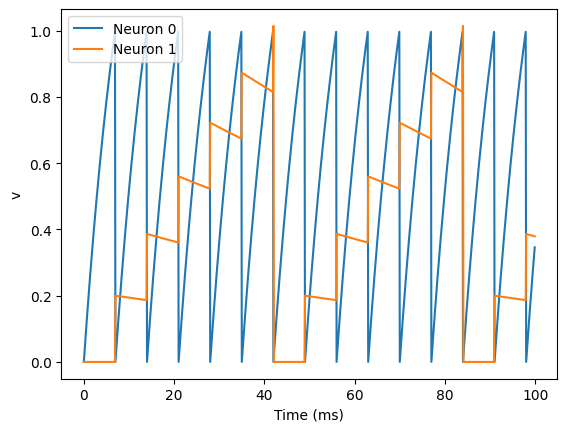

In [7]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0]
G.tau = [10, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plt.xlabel('Time (ms)')
plt.ylabel('v')
legend()

so here we have made two neurons. they are subject to the same DE, but with different values for the params I and tau. for the first neuron, I = 2, and for the second I = 0.  tau is also longer for the second neuron. threshold is 1, hence the rests seen, and there are no condiions on refactory neurons. 

without synapses, we see that we get the expected behaviour, for the second neuron, I = 0 therefore we are pulled to I = 0 , e.g. we see no evolution in that neurons potential. neuron 1 works as expected. resetting to 0 when spiking at 1mV. 

with synapses:
we define a synapse model that 'goes from source to target' ==? Synapses(source, target, ...). in this case, the source and target are the same, the group G. 
on_pre = 'v_post += 0.2' means when spike occurs in presynaptic neuron (on_pre) there is a change to the post of adding 0.2. 
what neurons? this is given by S.connect, creates a synapse between neurons 0 and 1. 

so you can see on the plot that when neuron 0 fires, 1 increases by 0.2 and begins to decay as its driven to 0, but then 0 fires again and it increaases. etc. 


we have hard code the 'weight' of the synapse to be 0.2, but we want this to be different for different synapses. 

WARNING    'tau' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


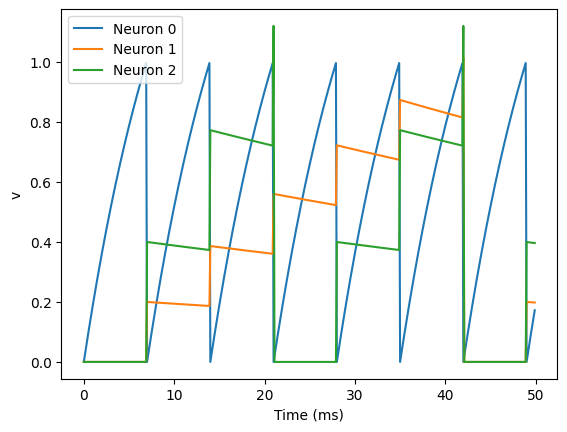

In [8]:
start_scope()

eqs = '''
dv/dt = (I - v) / tau : 1
I : 1
tau : second
'''

G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

#so neuron 0 wants to spike, rapidly. 

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')   #ntoe that this contains an equation string
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'

#connecting 0 to 1 and 2. the weight is variable and depends on index of target neuron. expect to see
#larger increases for the second neuron. 

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
plt.xlabel('Time (ms)')
plt.ylabel('v')
legend()

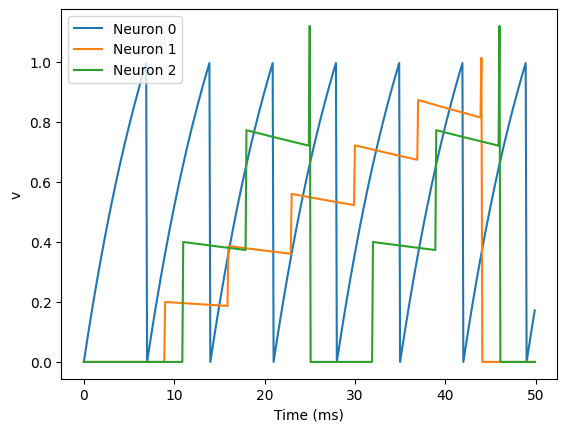

In [9]:
#will now introduce a delay

start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'
S.delay = 'j*2*ms'   #have just added this. this just delays when the neuron is updated.

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
plt.xlabel('Time (ms)')
plt.ylabel('v')
legend()



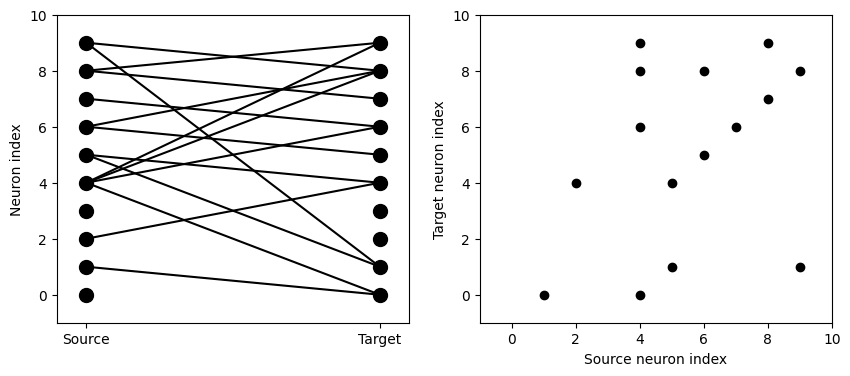

In [10]:
# More complex connectivity:

start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2)  #this line connects all pairs i and j with a probability 0.2 o long as  i isnt j.

 #have created a dummy neuron group and dummy synapse group.
 #we can visualise the connection!!!!!

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)   #this plots Ns vlaues at 0 e.g. on source mark
    plot(ones(Nt), arange(Nt), 'ok', ms=10)  #ok is black circle and ms is marker size
    for i, j in zip(S.i, S.j):     #this plots the connections, 0 to 1 being x values of lines, i, j being y values of lines
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    plt.ylabel('Neuron index')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    plt.xlim(-1, Ns)
    plt.ylim(-1, Nt)
    plt.xlabel('Source neuron index')
    plt.ylabel('Target neuron index')

visualise_connectivity(S)

WARNING    The object 'synapses_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\joshu\AppData\Local\Temp\ipykernel_536\3615279413.py', line 7, in <module>
    S = Synapses(G, G) [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\joshu\AppData\Local\Temp\ipykernel_536\3615279413.py', line 6, in <module>
    G = NeuronGroup(N, 'v:1') [brian2.core.base.unused_brian_object]
WARNING    The object 'synapses' is getting deleted, but was never included in a network. This probably means that

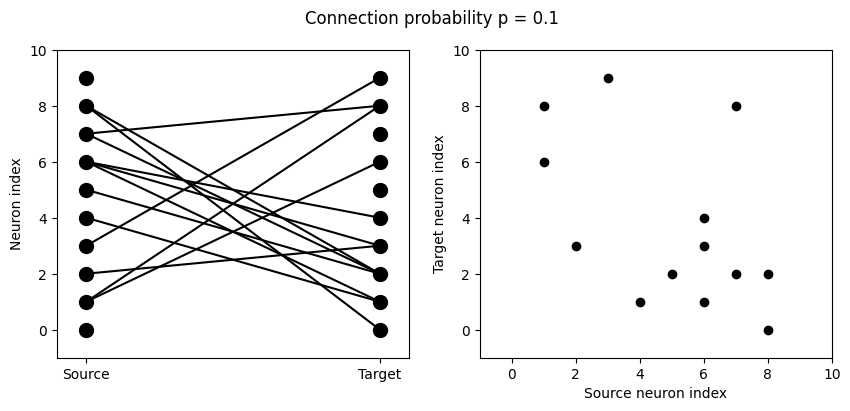

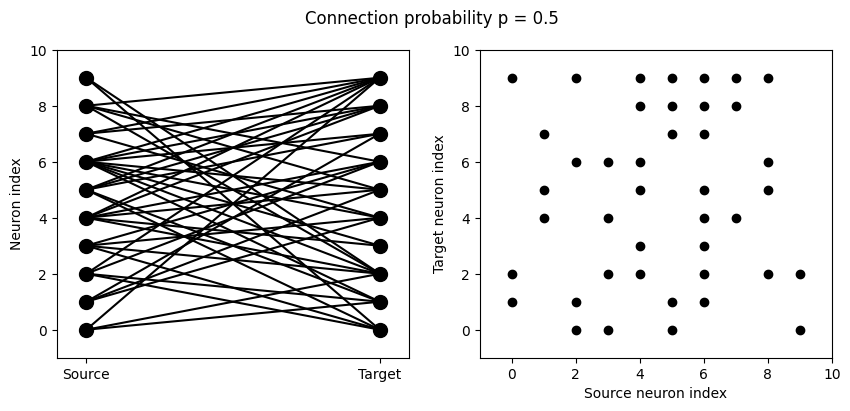

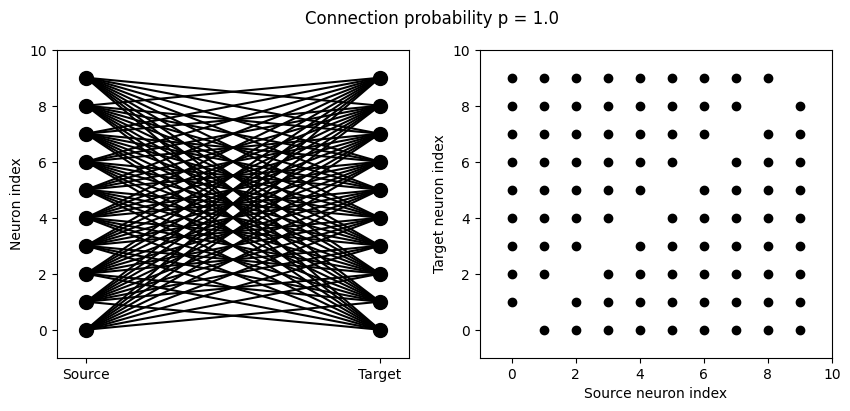

In [11]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

for p in [0.1, 0.5, 1.0]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('Connection probability p = ' + str(p))

what if we only connect neighbours? 

WARNING    The object 'synapses' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\joshu\AppData\Local\Temp\ipykernel_536\1534359980.py', line 7, in <module>
    S = Synapses(G, G) [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup_3' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\joshu\AppData\Local\Temp\ipykernel_536\1534359980.py', line 4, in <module>
    G = NeuronGroup(N, 'v:1') [brian2.core.base.unused_brian_object]


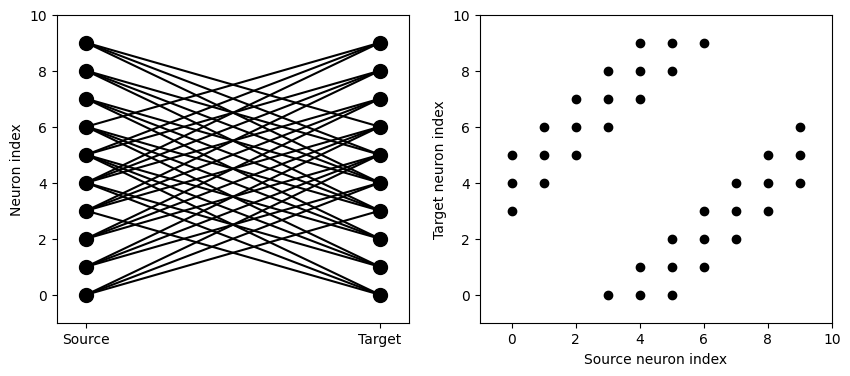

In [12]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(condition = 'abs(i-j)<6 and i!=j and abs(i-j)> 2')  #this connects neurons that are within 4 of each other, but not the same neuron
visualise_connectivity(S)

WARNING    The object 'synapses_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\joshu\AppData\Local\Temp\ipykernel_536\672433672.py', line 6, in <module>
    S = Synapses(G, G) [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\joshu\AppData\Local\Temp\ipykernel_536\672433672.py', line 4, in <module>
    G = NeuronGroup(N, 'v:1') [brian2.core.base.unused_brian_object]


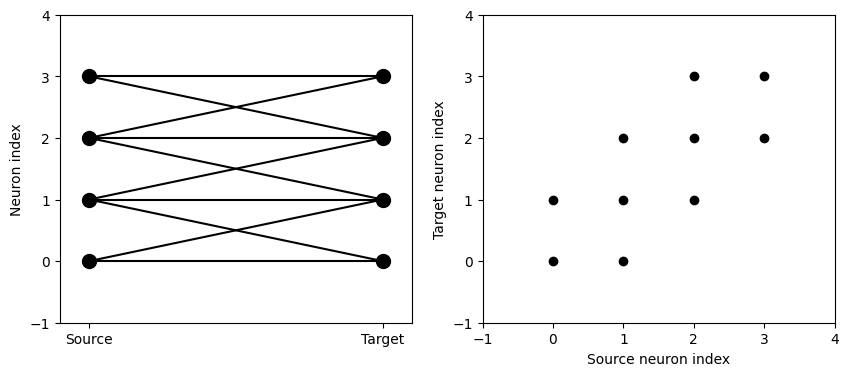

In [13]:
#can also use a 'Generator syntax' to create these connections more efficiently. this is better for larger networks.

start_scope()

N = 4
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(j='k for k in range(i-1, i+2)', skip_if_invalid=True)  #seems that this just looks for any relation between i and j
visualise_connectivity(S)

WARNING    The object 'synapses' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\joshu\AppData\Local\Temp\ipykernel_536\3555268165.py', line 8, in <module>
    S = Synapses(G, G) [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup_3' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\joshu\AppData\Local\Temp\ipykernel_536\3555268165.py', line 6, in <module>
    G = NeuronGroup(N, 'v:1') [brian2.core.base.unused_brian_object]


Text(0, 0.5, 'Target neuron position (um)')

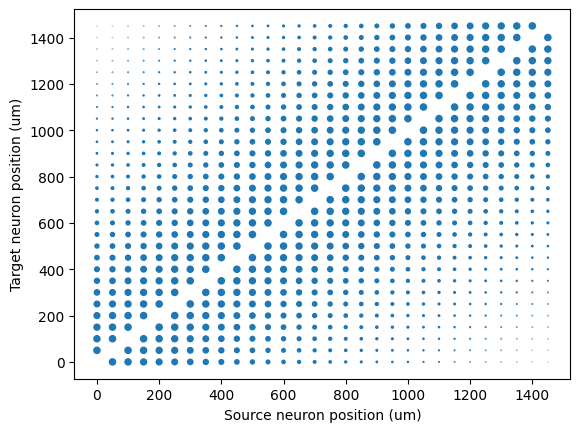

In [14]:
#can also specify the value of the weights with a string. imagine we give each neuron a spatial location, and have a distance dependent weighting!


start_scope()

N = 30
neuron_spacing = 50 * umeter
width = N/4.0*neuron_spacing

#Neuron has one variable x, its position
G = NeuronGroup(N, 'x : meter')
G.x = 'i*neuron_spacing'

#this means that for the 30 neurons, the position of the ith neuron is i times its index

#connect all synapces
S = Synapses(G, G, 'w : 1') #some general unitless weighting
S.connect(condition='i!=j')
S.w = 'exp(-(x_pre - x_post) ** 2 / (2 * width**2))'

scatter(S.x_pre/um, S.x_post/um, S.w*20)
plt.xlabel('Source neuron position (um)')
plt.ylabel('Target neuron position (um)')


We want to now be able to vary the strength of the synapse based on the precise timing of spikes from the presynaptic and postsynaptic neurons.
- by looking at the difference in these times, we can enforce that if the presynaptic neuron fires before the postsynaptic neuron then the synapse is strengthened. e.g. strengthened if moving in assumed order. otherwise, weakened. You also dont want much change to the weights for firings with larger temporal seperation. the following function achieves this.  

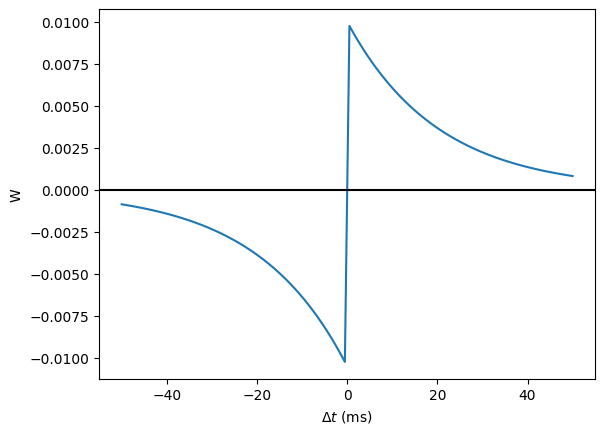

In [15]:
tau_pre = tau_post = 20*ms
A_pre = 0.01
A_post = -A_pre*1.05
delta_t = linspace(-50, 50, 100)*ms
W = where(delta_t>0, A_pre*exp(-delta_t/tau_pre), A_post*exp(delta_t/tau_post))
plot(delta_t/ms, W)
plt.xlabel(r'$\Delta t$ (ms)')
plt.ylabel('W')
axhline(0, ls='-', c='k');

STDP is a spiking time dependent plasticity - this is normally defined by an equation that relates changes in the weighting to a function of the difference in presynaptic spike times and post synaptic spike times. summed over both. a common funciton is  above.

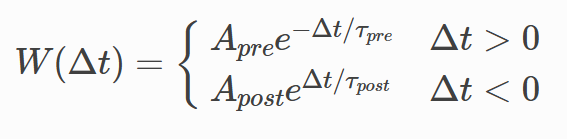 

we dont want to have to sum over all spike pairs. also note that a neuron cant remember all of its previous spike times. define traces of pre and post synapcit activity. when a presynapcit spike occurs, the presynapcit trace is updated and the weight is modified. so we have a formulation reliant upon differential equations, and spike events, and can turn that into brian code:

we wish to use variables that summarise the effect of past spikes in a single decaying value. a_pre will decay exponentially but increase by A_pre each time a presynaptic spike occurs. a_post similar, tracking post synapse and increasing by A_post. Note also that the weight is then increased based on how active the postsynaptic neuron has been recently. e.g. upon pre spike, greater weight for recent post spike. likewise for a post spike, greater weights for recent pre spike. this is what we want. 

WARNING    The object 'synapses_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\joshu\AppData\Local\Temp\ipykernel_536\2167547185.py', line 17, in <module>
    S = Synapses(G, G, 'w : 1') #some general unitless weighting [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\joshu\AppData\Local\Temp\ipykernel_536\2167547185.py', line 11, in <module>
    G = NeuronGroup(N, 'x : meter') [brian2.core.base.unused_brian_object]
WARNING    't' is an internal variable of group 'neurongroup_3',

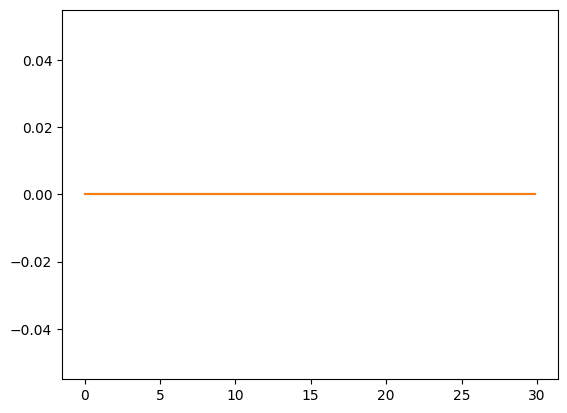

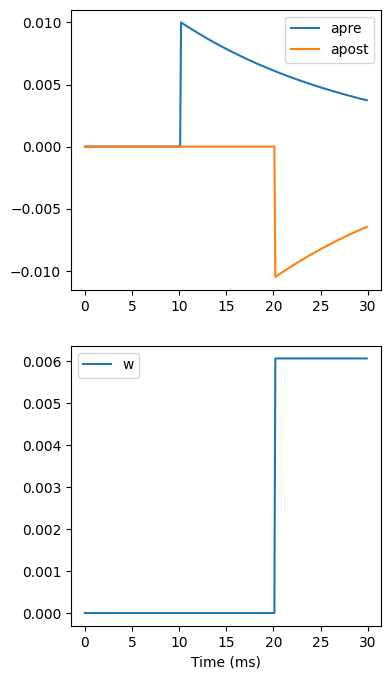

In [16]:
start_scope()


start_scope()

# taupre = taupost = 20*ms
# wmax = 0.01
# Apre = 0.01
# Apost = -Apre*taupre/taupost*1.05

# G = NeuronGroup(1, 'v:1', threshold='v>1', reset='')

# S = Synapses(G, G,
#              '''
#              w : 1
#              dapre/dt = -apre/taupre : 1 (event-driven)
#              dapost/dt = -apost/taupost : 1 (event-driven)
#              ''',
#              on_pre='''
#              v_post += w
#              apre += Apre
#              w = clip(w+apost, 0, wmax)
#              ''',
#              on_post='''
#              apost += Apost
#              w = clip(w+apre, 0, wmax)
#              ''')

#some comments on these strings:
#- event driven Brian only updates apre and apost at the time of a spike
#- there are then on pre and on post strings
# on pre does three things:
#-- it actually applies the weight to the post synaptic neuron
#-- it updates apre
#-- it updates the weight but clamps it to be between 0 and wmax

#on post does two things:
#-- it updates apost
#-- it updates the weight but clamps it to be between 0 and wmax
# note that it doesnt modify v. 

#now we see what happens when pre before post:


taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(2, 'v:1', threshold='t>(1+i)*10*ms', refractory=100*ms)

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''', method='linear')
S.connect(i=0, j=1)

#have made the threshold such that at times 10 and 20ms, the first and second neuron spike respectively. the threshold is any TIME greater than those values, not any potential
#also have made event driven with clock driven to see how they change in time

#so expect that when pre fires at 10ms, potential of post increases (physical understanding),  apre increases. when post fires we dont change the 
#potential of the pre neuron (physically), and we update the post trace 
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)
M_N = StateMonitor(G, 'v', record=True)
run(30*ms)

plot(M_N.t/ms, M_N.v[0])
plot(M_N.t/ms, M_N.v[1])
plt.show()

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
plt.xlabel('Time (ms)');

WARNING    't' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 41.5 * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    't' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 41.5 * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    't' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 41.5 * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


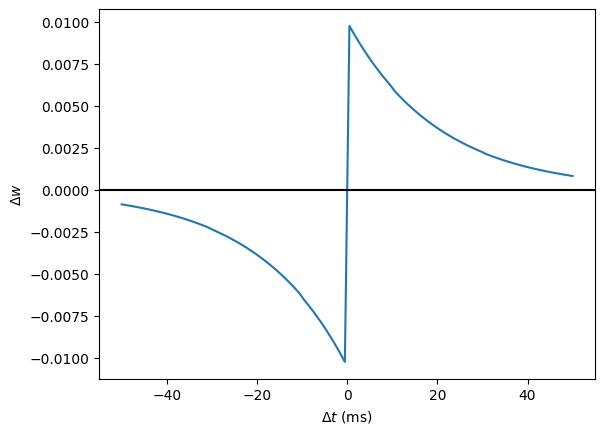

In [17]:
start_scope()

taupre = taupost = 20*ms
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
tmax = 50*ms
N = 100

# Presynaptic neurons G spike at times from 0 to tmax
# Postsynaptic neurons G spike at times from tmax to 0
# So difference in spike times will vary from -tmax to +tmax
G = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
H = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
G.tspike = 'i*tmax/(N-1)'
H.tspike = '(N-1-i)*tmax/(N-1)'

S = Synapses(G, H,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             apre += Apre
             w = w+apost
             ''',
             on_post='''
             apost += Apost
             w = w+apre
             ''')
S.connect(j='i')

run(tmax+1*ms)

plot((H.tspike-G.tspike)/ms, S.w)
plt.xlabel(r'$\Delta t$ (ms)')
plt.ylabel(r'$\Delta w$')
plt.axhline(0, ls='-', c='k');